# Практическое задание к уроку 7

In [179]:
from typing import Dict
from copy import deepcopy
from tqdm import tqdm

import random
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import seaborn as sns
import matplotlib.pyplot as plt

### Выбрать один из алгоритмов представленных по ссылке и реализовать его.

In [222]:
### Равномерный кроссовер
def crossover_equable(parents, children_size):
    children = np.empty(children_size)
    cross=np.random.randint(0,2,size=children_size[1])
    for i in range(children_size[0]):
            for j in cross:
                parent1_idx = i % parents.shape[0]
                parent2_idx = (i+1) % parents.shape[0]
                if cross[j]==1:
                    children[i,j]=parents[parent1_idx,j]
                else:
                    children[i,j]=parents[parent2_idx,j]
    return children

In [334]:
### Кроссовер Ордена Дэвиса (OX1)
def crossover_OX1(parents, children_size):
    point1=np.random.randint(0, children_size[1]/2)
    
    point2=np.random.randint(point1, children_size[1])
    idx_1 = range(point1,point2)
    idx_2 = range(point1)
    idx_3 = range(point2,children_size[1])
    children = np.empty(children_size)

    for i in range(children_size[0]):
                    parent1_idx = i % parents.shape[0]
                    parent2_idx = (i+1) % parents.shape[0]

                    children[i, idx_1] = parents[parent1_idx, idx_1]
                    children[i, idx_2] = parents[parent2_idx, range(point1,point1+len(idx_2))]
                    children[i, idx_3] = parents[parent2_idx, range(0,len(idx_3))]
                 
    return children

### 2. *вы также можете попробовать подставить его в реализацию в методичке, часть 1

In [224]:
data = pd.read_csv("train.csv")
data = data.sample(50000).reset_index(drop=True)

data.head(n=2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,COMMUNICATION_TYPE
0,432687,0,Cash loans,M,Y,Y,2,225000.0,450000.0,30204.0,...,0,0,0,0.0,0.0,0.0,4.0,1.0,5.0,PUSH
1,420893,0,Cash loans,M,Y,Y,0,225000.0,753925.5,59697.0,...,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,PUSH


In [225]:
x_train, x_valid = train_test_split(
    data, train_size=15000, random_state=1
)
x_train = x_train.reset_index(drop=True)
x_valud = x_valid.reset_index(drop=True)

y_train, y_valid = x_train["TARGET"], x_valid["TARGET"]

In [226]:
def init_population(number_of_parents: int) -> Dict[str, np.array]:
    """
    Инициализация начальной популяции генетического алгоритма.

    Parameters
    ----------
    number_of_parents: int
        Количество родителей в популяции.

    Returns
    -------
    population: dict, Dict[str, np.array]
        Словарь с начальной популяцией.

    """
    population = {
        "max_depth": np.empty([number_of_parents, 1], dtype=np.uint8),
        "min_child_weight": np.empty([number_of_parents, 1], dtype=np.uint8),
        "subsample": np.empty([number_of_parents, 1]),
        "colsample_bytree": np.empty([number_of_parents, 1]),
        "gamma": np.empty([number_of_parents, 1])
    }

    for i in range(number_of_parents):
        population["max_depth"][i] = round(
            random.randrange(1, 10, step=1)
        )
        population["min_child_weight"][i] = round(
            random.uniform(0.01, 10), 2
        )
        population["subsample"][i] = round(
            random.uniform(0.01, 1), 2
        )
        population["colsample_bytree"][i] = round(
            random.uniform(0.01, 1), 2
        )
        population["gamma"][i] = round(
            random.uniform(0.01, 10), 2
        )
    return population

In [325]:
def train_population(population,
                     xgb_train: xgb.DMatrix,
                     xgb_valid: xgb.DMatrix,
                     y_valid: pd.Series
                     ):
    scores = []
    for i in range(population.shape[0]):
        xgb_params = {
            "booster": "gbtree",
            "objective": "binary:logistic",
            "learning_rate": 0.1,
            "max_depth": int(population[i][0]),
            "min_child_weight": population[i][1],
            "subsample": population[i][2],
            "colsample_bytree": population[i][3],
            "gamma": population[i][4],
            "eval_metric": "auc",
            "nthread": 6,
            "seed": 27
        }
        
        model = xgb.train(
            params=xgb_params,
            dtrain=xgb_train,
            evals=[(xgb_train, "train"), (xgb_valid, "valid")],
            early_stopping_rounds=50,
            num_boost_round=1000,
            verbose_eval=25,
        )
        y_pred = model.predict(xgb_valid)
        score = roc_auc_score(y_valid, y_pred)
        scores.append(score)
        print("="*84)
        

    return scores

In [228]:
def select_new_parents(population: np.array, scores: list, num_parents: int):
    """
    Выбор оптимальный параметров популяции на основе
    значений метрики качества ROC-AUC.

    Parameters
    ----------
    population: np.array
        Матрица с текущим значением популяции.

    scores: List[float]
        Список со значениями метрики качества.

    num_parents: int
        Количество родителей, которые требуется отобрать.

    Returns
    -------
    selected_parents: np.array
        Значение популяции, отобранное на основе метрики качества.

    """
    scores = deepcopy(scores)
    selected_parents = np.empty((
        num_parents, population.shape[1]
    ))

    for parent_id in range(num_parents):
        best_result_id = np.where(scores == np.max(scores))
        best_result_id = best_result_id[0][0]

        selected_parents[parent_id, :] = population[best_result_id, :]
        scores[best_result_id] = -1

    return selected_parents

In [229]:
number_of_parents = 8
number_of_parents_mating = 4
number_of_parameters = 5
number_of_generation = 6

population_size = (number_of_parents, number_of_parameters)
scores_history = np.empty([number_of_generation+1, number_of_parents])

params_history = np.empty([(number_of_generation+1) * number_of_parents, number_of_parameters])

In [230]:
population = init_population(number_of_parents)

population = np.concatenate((
    population["max_depth"],
    population["min_child_weight"],
    population["subsample"],
    population["colsample_bytree"],
    population["gamma"]), axis=1)

params_history[0:number_of_parents, :] = population

In [231]:
def mutation(crossover, number_of_parameters):
    """
    Мутация объектов популяции, получение новых значений
    гиперпараметров для проверки гипотезы о повышении качества
    работы модели.

    Parameters
    ----------
    crossover: np.array
        Исходные объекты популяции.

    number_of_parameters: int
        Количество параметров.

    Returns
    -------
    crossover: np.array
        Мутированные объекты популяции.

    """
    min_max_values = np.zeros((number_of_parameters, 2))

    min_max_values[0, :] = [1, 15] # ограничение для max_depth
    min_max_values[1, :] = [0, 10] # ограничение для min_child_weight
    min_max_values[2, :] = [0.01, 1] # ограничение для subsample
    min_max_values[3, :] = [0.01, 1] # ограничение для colsample_bytree
    min_max_values[4, :] = [0.01, 10] # ограничение для gamma
    parameter_selected = np.random.randint(0, 5, 1)

    if parameter_selected == 0:
        mutation_value = np.random.randint(-5, 5, 1)
    elif parameter_selected == 1:
        mutation_value = round(np.random.uniform(5, 5), 2)
    elif parameter_selected == 2:
        mutation_value = round(np.random.uniform(-0.5, 0.5), 2)
    elif parameter_selected == 3:
        mutation_value = round(np.random.uniform(-0.5, 0.5), 2)
    elif parameter_selected == 4:
        mutation_value = round(np.random.uniform(-2, 2), 2)

    for idx in range(crossover.shape[0]):
        crossover[idx, parameter_selected] = crossover[idx, parameter_selected] + mutation_value
        if crossover[idx, parameter_selected] > min_max_values[parameter_selected, 1]:
            crossover[idx, parameter_selected] = min_max_values[parameter_selected, 1]
        else:
            crossover[idx, parameter_selected] = min_max_values[parameter_selected, 0]

    return crossover

### Равномерный кроссовер

In [232]:
num_features = x_train.select_dtypes(exclude=["object"]).columns
x_train, x_valid = x_train[num_features], x_valid[num_features]

to_drop = ["SK_ID_CURR", "TARGET"]
x_train = x_train.drop(to_drop, axis=1)
x_valid = x_valid.drop(to_drop, axis=1)

In [233]:
xgb_train = xgb.DMatrix(
    data=x_train, label=y_train
)
xgb_valid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [234]:
for generation in tqdm(range(number_of_generation)):
    best_score, mean_score = np.max(scores_history), np.mean(scores_history)
    print(f"All-history: Best ROC-AUC = {round(best_score, 4)}, Mean ROC-AUC = {round(mean_score, 4)}")

    scores = train_population(
        population=population,
        xgb_train=xgb_train,
        xgb_valid=xgb_valid,
       y_valid=y_valid)

    scores_history[generation, :] = scores

    parents = select_new_parents(
        population=population,
        scores=scores,
        num_parents=4)

    children = crossover_equable(
        parents=parents,
        children_size=(population_size[0] - parents.shape[0], 5)
    )
    children_mutated = mutation(children, number_of_parameters=5)
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]:, :] = children_mutated

    params_history[(generation+1)*8 : (generation+1)*8+8 , :] = population
    clear_output()

scores_history = pd.DataFrame(scores_history)
scores_history = scores_history.loc[:5]









100%|████████████████████████████████████████████| 6/6 [05:59<00:00, 59.89s/it]


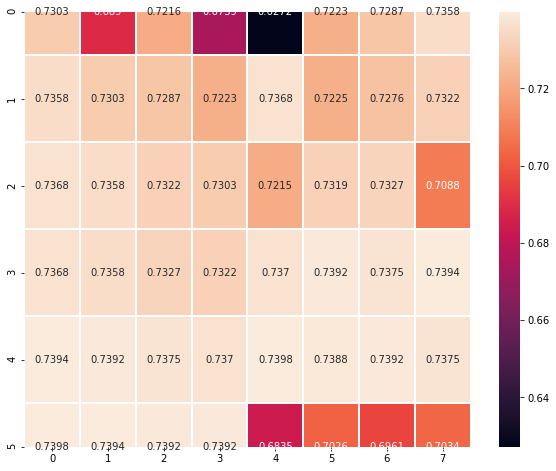

In [235]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(scores_history, annot=True, fmt='.4g', linewidths=1, ax=axes)

### Кроссовер Ордена Дэвиса (OX1)

In [335]:
number_of_parents = 8
number_of_parents_mating = 4
number_of_parameters = 5
number_of_generation = 6

population_size = (number_of_parents, number_of_parameters)
scores_history = np.empty([number_of_generation+1, number_of_parents])

params_history = np.empty([(number_of_generation+1) * number_of_parents, number_of_parameters])

In [336]:
population = init_population(number_of_parents)

population = np.concatenate((
    population["max_depth"],
    population["min_child_weight"],
    population["subsample"],
    population["colsample_bytree"],
    population["gamma"]), axis=1)

params_history[0:number_of_parents, :] = population

In [337]:
for generation in tqdm(range(number_of_generation)):
    best_score, mean_score = np.max(scores_history), np.mean(scores_history)
    print(f"All-history: Best ROC-AUC = {round(best_score, 4)}, Mean ROC-AUC = {round(mean_score, 4)}")

    scores = train_population(
        population=population,
        xgb_train=xgb_train,
        xgb_valid=xgb_valid,
       y_valid=y_valid)

    scores_history[generation, :] = scores

    parents = select_new_parents(
        population=population,
        scores=scores,
        num_parents=4)

    children = crossover_OX1(
        parents=parents,
        children_size=(population_size[0] - parents.shape[0], 5)
    )
    children_mutated = mutation(children, number_of_parameters=5)
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]:, :] = children_mutated

    params_history[(generation+1)*8 : (generation+1)*8+8 , :] = population
    clear_output()

scores_history = pd.DataFrame(scores_history)
scores_history = scores_history.loc[:5]

































 67%|█████████████████████████████▎              | 4/6 [02:23<01:16, 38.47s/it]

All-history: Best ROC-AUC = 6.5, Mean ROC-AUC = 2.7517
[0]	train-auc:0.63585	valid-auc:0.64902
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[25]	train-auc:0.72434	valid-auc:0.71228
[50]	train-auc:0.74441	valid-auc:0.72694
[75]	train-auc:0.76042	valid-auc:0.73493
[100]	train-auc:0.76725	valid-auc:0.73731
[125]	train-auc:0.77169	valid-auc:0.73745
[150]	train-auc:0.77610	valid-auc:0.73810
[175]	train-auc:0.77809	valid-auc:0.73823
[200]	train-auc:0.77937	valid-auc:0.73848
[225]	train-auc:0.78234	valid-auc:0.73897
[250]	train-auc:0.78540	valid-auc:0.73894
[275]	train-auc:0.78776	valid-auc:0.73894
[300]	train-auc:0.78984	valid-auc:0.73854
Stopping. Best iteration:
[266]	train-auc:0.78701	valid-auc:0.73906

[0]	train-auc:0.63586	valid-auc:0.64909
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[25]	trai

XGBoostError: value 2 for Parameter subsample exceed bound [0,1]
subsample: Row subsample ratio of training instance.

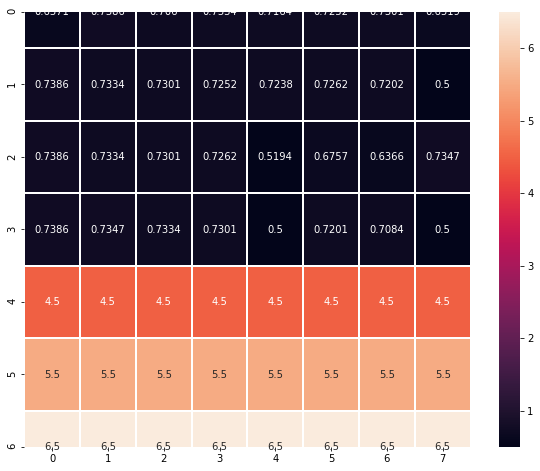

In [338]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(scores_history, annot=True, fmt='.4g', linewidths=1, ax=axes)